In [94]:
# transformer_testing.py
import os, sys, json
import joblib
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
import logging

logging.basicConfig(level=logging.INFO, format='%(message)s')

# ---------------------------------------------------------------------
# Paths / config
# ---------------------------------------------------------------------
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
DEV_DIR     = os.path.join(PROJECT_DIR, "dev/transformer")
sys.path.append(DEV_DIR)

from transformer import MultiomicTransformer
from transformer_dataset import MultiomicTransformerDataset
from transformer_training import prepare_dataloader
import eval

SAMPLE_NAME = "mESC"
CHROM_ID    = "chr19"
TRAINING_RUN_NAME = "model_training_01_10_16_03_45"

TRANSFORMER_DATA_DIR = os.path.join(DEV_DIR, f"transformer_data/{SAMPLE_NAME}")
COMMON_DIR           = os.path.join(DEV_DIR, "transformer_data/common")
OUTPUT_DIR           = os.path.join(PROJECT_DIR, "output/transformer_testing_output")
TEST_DIR             = os.path.join(OUTPUT_DIR, f"{SAMPLE_NAME}/{CHROM_ID}/{TRAINING_RUN_NAME}")  # where checkpoint lives


GROUND_TRUTH_DIR = os.path.join(PROJECT_DIR, "ground_truth_files")
OUT_DIR = os.path.join(TEST_DIR, "tf_gradient_attributions")
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH  = 32
TG_CHUNK = 64

In [95]:
beeline_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "mESC_beeline_ChIP-seq.csv"))
beeline_ground_truth = beeline_ground_truth.rename(columns={"Gene1":"TF", "Gene2":"TG"})
beeline_ground_truth

,TF,TG
0,ADNP,MIS18BP1
1,ADNP,EXD1
2,ADNP,CHP1
3,ADNP,OSCAR
4,ADNP,NDUFA3
...,...,...
977836,ZIC3,ZFP36L3
977837,ZIC3,ZFP499
977838,ZIC3,ZFP57
977839,ZIC3,ZFP91


In [96]:
orti_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "mESC_beeline_ChIP-seq.csv"))
orti_ground_truth = orti_ground_truth.rename(columns={"Gene1":"TF", "Gene2":"TG"})
orti_ground_truth

,TF,TG
0,ADNP,MIS18BP1
1,ADNP,EXD1
2,ADNP,CHP1
3,ADNP,OSCAR
4,ADNP,NDUFA3
...,...,...
977836,ZIC3,ZFP36L3
977837,ZIC3,ZFP499
977838,ZIC3,ZFP57
977839,ZIC3,ZFP91


In [97]:
rn115_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "rn115_chipseq.tsv"), sep="\t")
rn115_ground_truth = rn115_ground_truth.rename(columns={"sourceName":"TF", "targetName":"TG"})
rn115_ground_truth = rn115_ground_truth[["TF", "TG"]]
rn115_ground_truth

,TF,TG
0,CHD7,APOA1
1,CHD7,ARHGAP26
2,CHD7,ATP11A
3,CHD7,ATP5O
4,CHD7,AXIN1
...,...,...
133970,ESRRB,GNB2
133971,ESRRB,CCDC37
133972,ESRRB,FAM161A
133973,ESRRB,CSF1


In [3]:
gene_near_peaks_df = pd.read_parquet(os.path.join(TRAINED_MODEL_DATASET_DIR, "genes_near_peaks_chr1.parquet"))
training_log_df = pd.read_csv(os.path.join(TRAINED_MODEL_DIR, "training_log.csv"), header=0, index_col=0)

In [ ]:
def plot_per_gene_correlation_scatterplot(model, dataloader, gpu_id=0, outpath=None):
    model.eval()
    preds, tgts = [], []
    with torch.no_grad():
        for atac_wins, tf_tensor, targets, bias in dataloader:
            atac_wins, tf_tensor, targets, bias = (
                atac_wins.to(gpu_id),
                tf_tensor.to(gpu_id),
                targets.to(gpu_id),
                bias.to(gpu_id)
            )
            output = model(atac_wins, tf_tensor)
            preds.append(output.cpu().numpy())
            tgts.append(targets.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    tgts  = np.concatenate(tgts, axis=0)

    # inverse-transform
    # preds_rescaled = scaler.inverse_transform(preds)
    # tgts_rescaled  = scaler.inverse_transform(tgts)
    preds_rescaled = preds
    tgts_rescaled  = tgts

    corr, _ = pearsonr(preds_rescaled.ravel(), tgts_rescaled.ravel())
    print(f"Test Pearson correlation: {corr:.3f}")

    plt.figure(figsize=(6,6))
    plt.scatter(tgts_rescaled, preds_rescaled, alpha=0.5, s=5)
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.title(f"Predicted vs True (r={corr:.3f})")
    plt.plot([tgts_rescaled.min(), tgts_rescaled.max()],
             [tgts_rescaled.min(), tgts_rescaled.max()], 'r--')
    if outpath:
        plt.savefig(outpath, dpi=300)
    else:
        plt.show()

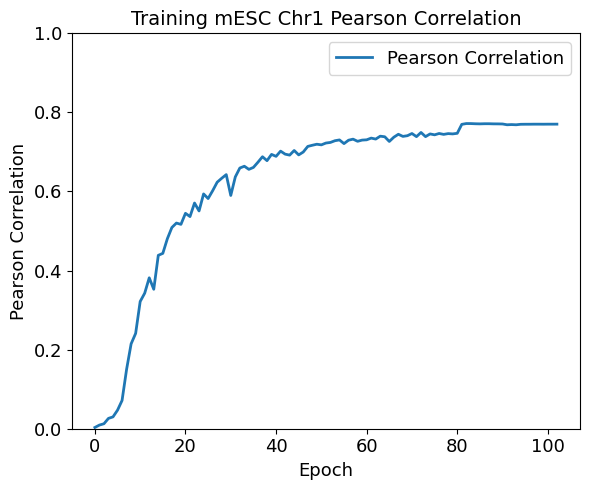

In [48]:
def plot_pearson_corr_across_epochs(df):
    fig = plt.figure(figsize=(6, 5))
    plt.plot(df.index, df["Pearson"], linewidth=2, label="Pearson Correlation")

    plt.title("Training mESC Chr1 Pearson Correlation", fontsize=14)
    plt.ylim((0,1))
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    plt.xlabel("Epoch", fontsize=13)
    plt.ylabel("Pearson Correlation", fontsize=13)
    plt.legend(fontsize=13)
    plt.tight_layout()
    
    return fig

fig = plot_pearson_corr_across_epochs(training_log_df)
fig.savefig(os.path.join(TRAINED_MODEL_DIR, "eval_results_pearson_corr.png"), dpi=300)
fig.show()

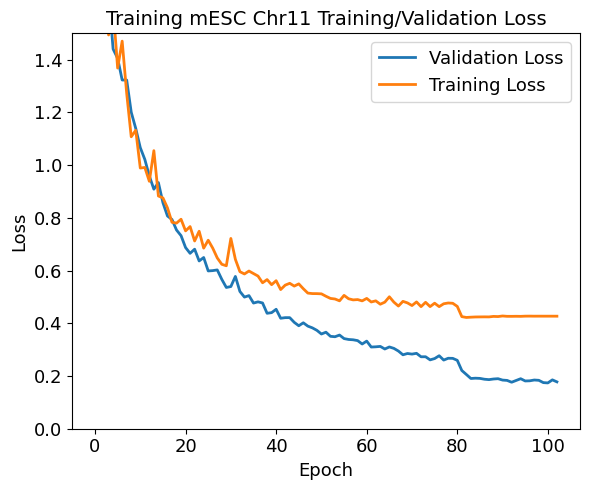

In [49]:
def plot_train_val_loss(df):
    fig = plt.figure(figsize=(6, 5))
    plt.plot(df.index, df["Train Loss"], linewidth=2, label="Validation Loss")
    plt.plot(df.index, df["Val Loss"], linewidth=2, label="Training Loss")

    plt.title("Training mESC Chr11 Training/Validation Loss", fontsize=14)
    plt.ylim((0,1.5))
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    plt.xlabel("Epoch", fontsize=13)
    plt.ylabel("Loss", fontsize=13)
    plt.legend(fontsize=13)
    plt.tight_layout()
    
    return fig
    
fig = plot_train_val_loss(training_log_df)
fig.savefig(os.path.join(TRAINED_MODEL_DIR, "eval_results_training_loss.png"), dpi=300)
fig.show()

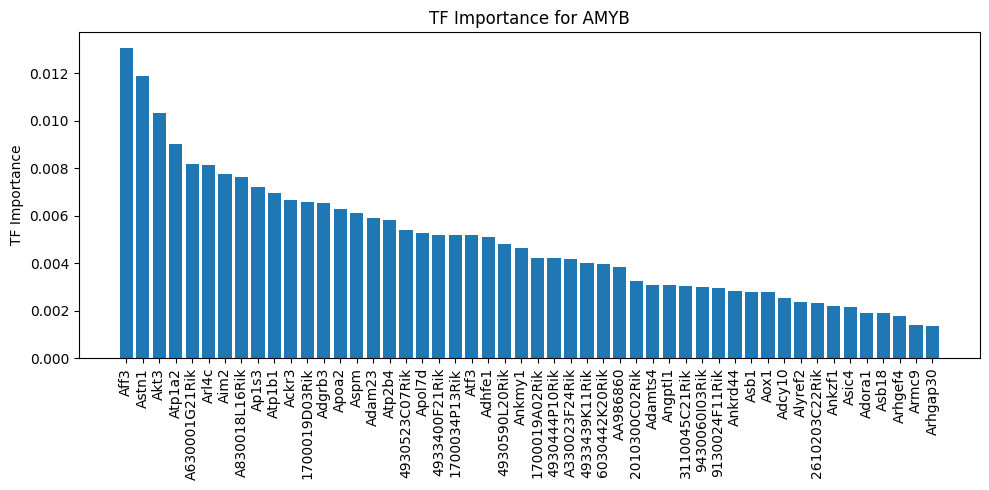

In [41]:
tf_imp_dir = os.path.join(TRAINED_MODEL_DIR, "tf_gradient_attributions")
            
tf_importance_df = pd.read_csv(os.path.join(tf_imp_dir, "tf_importance_matrix.csv"), header=0, index_col=0)

fig = plt.figure(figsize=(10,5))

selected_tg = tf_importance_df.index[0]
selected_tf_row = tf_importance_df.iloc[0]
selected_tf_row = selected_tf_row.iloc[:50].sort_values(ascending=False)

plt.xticks(rotation=90, fontsize=10)
plt.bar(x=selected_tf_row.index, height=selected_tf_row)
plt.title(f"TF Importance for {selected_tg}")
plt.ylabel("TF Importance")
plt.tight_layout()
plt.show()

In [28]:
tf_importance_df.head()

,1700019A02Rik,1700019D03Rik,1700034P13Rik,2010300C02Rik,2610203C22Rik,3110045C21Rik,4930444P10Rik,4930523C07Rik,4930590L20Rik,4933400F21Rik,...,Vash2,Vil1,Wnt6,Xkr4,Xkr9,Xpr1,Yod1,Zbtb41,Zc3h11a,Zdbf2
AMYB,0.004220,0.006596,0.005182,0.003253,0.002318,0.003053,0.004211,0.005405,0.004813,0.005186,...,0.002691,0.003386,0.009207,0.007730,0.003084,0.004112,0.004474,0.003815,0.006242,0.005562
AP-1,0.005143,0.005806,0.004755,0.004837,0.003597,0.003996,0.003246,0.006092,0.002857,0.002182,...,0.003742,0.004767,0.005110,0.011932,0.003296,0.002594,0.003632,0.003842,0.003251,0.004480
Atoh1,0.000603,0.002953,0.001267,0.001498,0.001074,0.001701,0.001185,0.001209,0.001636,0.000562,...,0.000728,0.001632,0.002343,0.002393,0.001654,0.001101,0.000922,0.000295,0.000677,0.002442
HNF4a,0.006466,0.007639,0.006827,0.001739,0.003435,0.006905,0.002758,0.005162,0.002130,0.003887,...,0.002809,0.004779,0.008591,0.010892,0.006066,0.007599,0.002543,0.004621,0.003582,0.011574
HNF6,0.008511,0.019434,0.012171,0.008647,0.003662,0.006858,0.023214,0.009014,0.008767,0.006695,...,0.015932,0.014045,0.027084,0.040268,0.013967,0.015193,0.007836,0.009559,0.014393,0.011150


In [5]:
chip_df = pd.read_csv(GROUND_TRUTH_FILE, header=0, index_col=None)
chip_edges = set(zip(chip_df["Gene1"].str.upper(), chip_df["Gene2"].str.upper()))

In [6]:
tf_tg_pred = pd.read_csv(os.path.join(TRAINED_MODEL_DIR, "tf_gradient_attributions/scored_edges.tsv"), sep="\t", header=0, index_col=None)
tf_tg_pred.head()

,tf,tg,score,label
0,SOX2,IGFBP2,0.412768,1
1,SOX2,XKR4,0.369489,0
2,SOX2,ERBB4,0.302949,0
3,SOX2,SATB2,0.301250,0
4,SOX2,A830018L16RIK,0.283120,0


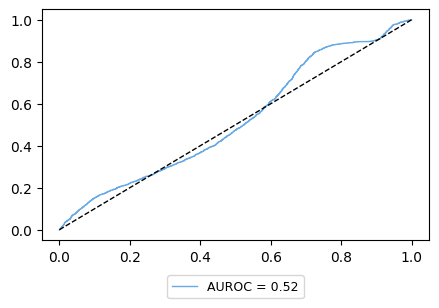

In [ ]:
from dev.notebooks.plotting import (
    plot_true_false_distribution, plot_true_false_boxplots, plot_true_false_scores_by_tf_boxplots,
    plot_true_false_scores_by_tf_barplots, plot_auroc
)

fig = plot_auroc(tf_tg_pred, score_col="score")
fig.show()

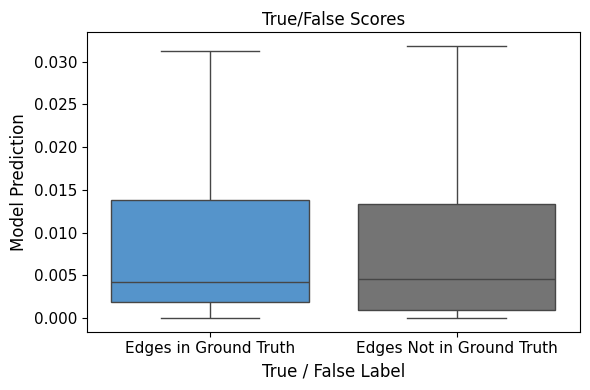

In [10]:
fig = plot_true_false_boxplots(
    df=tf_tg_pred,
    score_col="score",
    xlabel="True / False Label",
    ylabel = "Model Prediction"
    )

In [21]:
import importlib
import dev.notebooks.plotting
importlib.reload(dev.notebooks.plotting)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

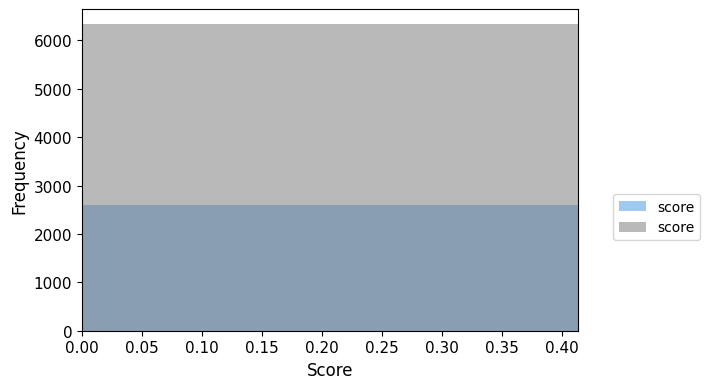

In [ ]:
fig = plot_true_false_distribution(
    true_series=tf_tg_pred[tf_tg_pred["label"] == 1]["score"],
    false_series=tf_tg_pred[tf_tg_pred["label"] == 0]["score"],
    )